In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

## Datasets

In [28]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
paths = [
            root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
            root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30",
            root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
            root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
            root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
            root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
            root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
            root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",
            root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
            root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
            root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
            root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
            root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
            root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
            root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
            root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
            root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
            root_path / "2021-06-10-12-59-59_e2e_ss4",
            root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
            root_path / "2021-06-10-13-51-34_e2e_ss12",
            root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
            root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
            root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
            root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
            root_path / "2021-06-14-11-22-05_e2e_rec_ss14",
            root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
            root_path / "2021-09-24-11-19-25_e2e_rec_ss10",
            root_path / "2021-09-24-11-40-24_e2e_rec_ss10_2",
            root_path / "2021-09-24-12-02-32_e2e_rec_ss10_3",
            root_path / "2021-09-24-12-21-20_e2e_rec_ss10_backwards",
            root_path / "2021-09-24-13-39-38_e2e_rec_ss11",
            root_path / "2021-09-30-13-57-00_e2e_rec_ss14",
            root_path / "2021-09-30-15-03-37_e2e_ss14_from_half_way",
            root_path / "2021-09-30-15-20-14_e2e_ss14_backwards",
            root_path / "2021-10-07-11-44-52_e2e_rec_ss3_backwards",
            root_path / "2021-10-07-13-22-35_e2e_rec_ss4_backwards",
            root_path / "2021-10-11-17-10-23_e2e_rec_last_part",
            root_path / "2021-10-11-17-14-40_e2e_rec_backwards",
            root_path / "2021-10-11-17-20-12_e2e_rec_backwards",
    
            root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
            root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
            root_path / "2021-06-14-11-22-05_e2e_rec_ss14",
            root_path / "2021-10-07-11-05-13_e2e_rec_ss3",
            root_path / "2021-09-24-14-03-45_e2e_rec_ss11_backwards",
    
            root_path / "2021-10-11-14-50-59_e2e_rec_vahi",
            root_path / "2021-10-14-13-08-51_e2e_rec_vahi_backwards"
]


dataset = NvidiaDataset(paths, camera="front_wide", transform=None)
positions_df = dataset.frames#[:15400]

/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-36-10_e2e_sulaoja_20_30: 12025
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-43-17_e2e_sulaoja_20_30: 6809
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-51-29_e2e_sulaoja_20_30: 5393
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-44-06_e2e_sulaoja_10_10: 3833
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-51-21_e2e_sulaoja_10_10: 3798
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-59-00_e2e_sulaoja_10_10: 687
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-07-56_e2e_sulaoja_20_30: 15626
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-17-19_e2e_sulaoja_20_30: 3218
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-06-31_e2e_rec_ss6: 3003
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-09-18_e2e_rec_ss6: 4551
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-36-16_e

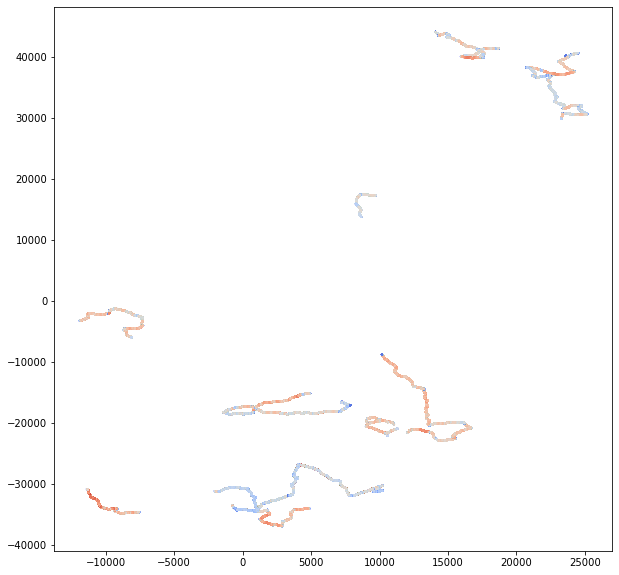

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(positions_df["position_x"], positions_df["position_y"],
            s=1,
            c=positions_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [35]:
velocity = 30
positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))
positions_df = positions_df[["position_x", "position_y", "position_x2", "position_y2", "yaw", "vehicle_speed", "image_path", "autonomous"]]

/tmp/ipykernel_57137/2942998590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
/tmp/ipykernel_57137/2942998590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))


In [38]:
positions_df = positions_df[positions_df['position_x'].notna()]
positions_df

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed,image_path,autonomous
1,11299.837048,-20889.408837,11277.019443,-20908.885923,-2.435013,10.908820,/media/romet/data2/datasets/rally-estonia/data...,False
2,11299.011255,-20890.127823,11276.259919,-20909.682278,-2.431617,11.087475,/media/romet/data2/datasets/rally-estonia/data...,False
3,11298.190688,-20890.845215,11275.508288,-20910.479590,-2.428099,10.969975,/media/romet/data2/datasets/rally-estonia/data...,False
4,11297.359741,-20891.574968,11274.741676,-20911.283421,-2.424829,10.947773,/media/romet/data2/datasets/rally-estonia/data...,False
5,11296.530407,-20892.304810,11273.996362,-20912.109274,-2.420576,11.021313,/media/romet/data2/datasets/rally-estonia/data...,False
...,...,...,...,...,...,...,...,...
13437,8653.050592,13849.532213,8663.094166,13821.263386,-1.229418,8.988350,/media/romet/data2/datasets/rally-estonia/data...,False
13438,8653.155896,13849.236891,8663.205386,13820.970165,-1.229209,8.990000,/media/romet/data2/datasets/rally-estonia/data...,False
13439,8653.257687,13848.951743,8663.315961,13820.688142,-1.228898,8.935287,/media/romet/data2/datasets/rally-estonia/data...,False
13440,8653.358300,13848.669388,8663.425468,13820.408954,-1.228584,8.957848,/media/romet/data2/datasets/rally-estonia/data...,False


In [40]:
positions_df.to_parquet('velocity_model/positions.parquet', compression='GZIP')

In [41]:
from velocity_model.velocity_model import VelocityModel

velocity_model = VelocityModel(positions_parquet='velocity_model/positions.parquet')

In [42]:
speed, distance = velocity_model.find_speed_for_position(8454., 15490., 1.95)
speed

8.009431966532162

/media/romet/data2/datasets/rally-estonia/dataset/2021-10-11-14-50-59_e2e_rec_vahi: 21211
Error mean: 0.20843148572596915, max: 2.319837469128543


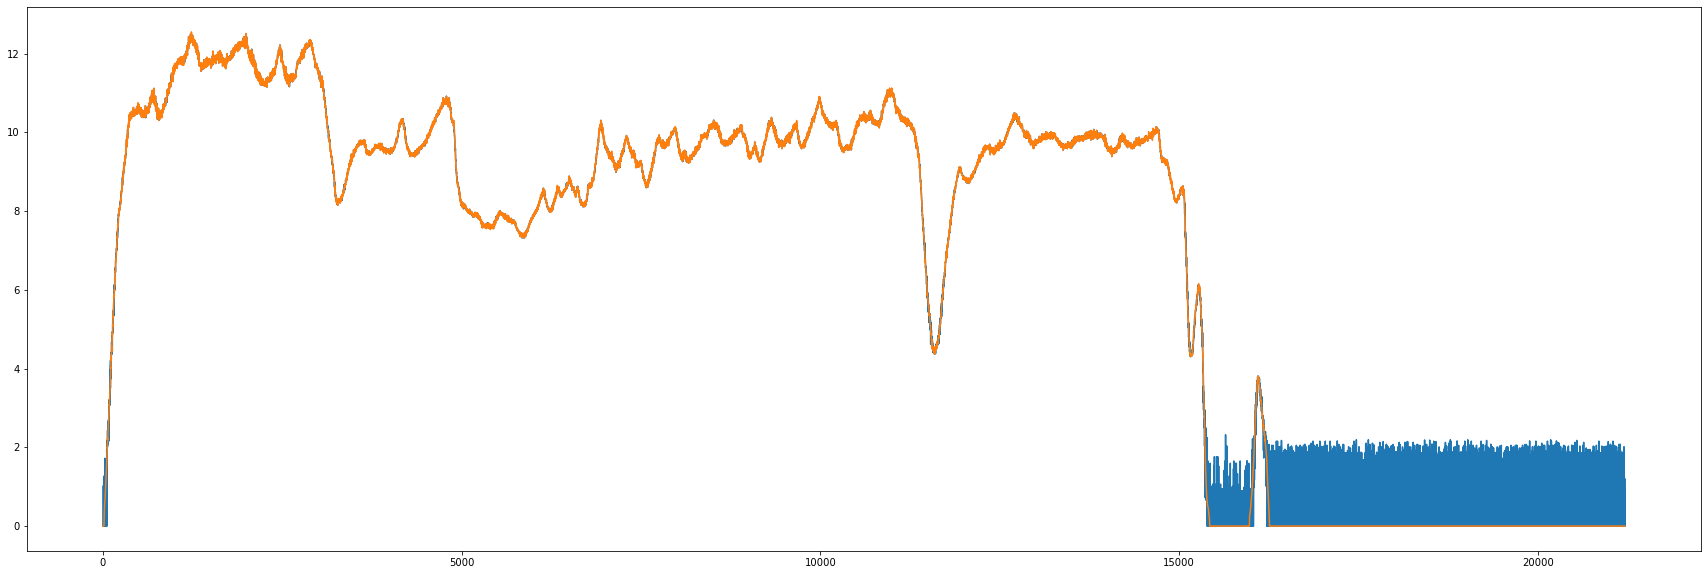

In [43]:
test_df = NvidiaDataset([root_path / "2021-10-11-14-50-59_e2e_rec_vahi"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.1, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: velocity_model.find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])

/media/romet/data2/datasets/rally-estonia/dataset/2021-10-14-13-08-51_e2e_rec_vahi_backwards: 13442
Error mean: 0.03462654362353848, max: 1.9418444068995324


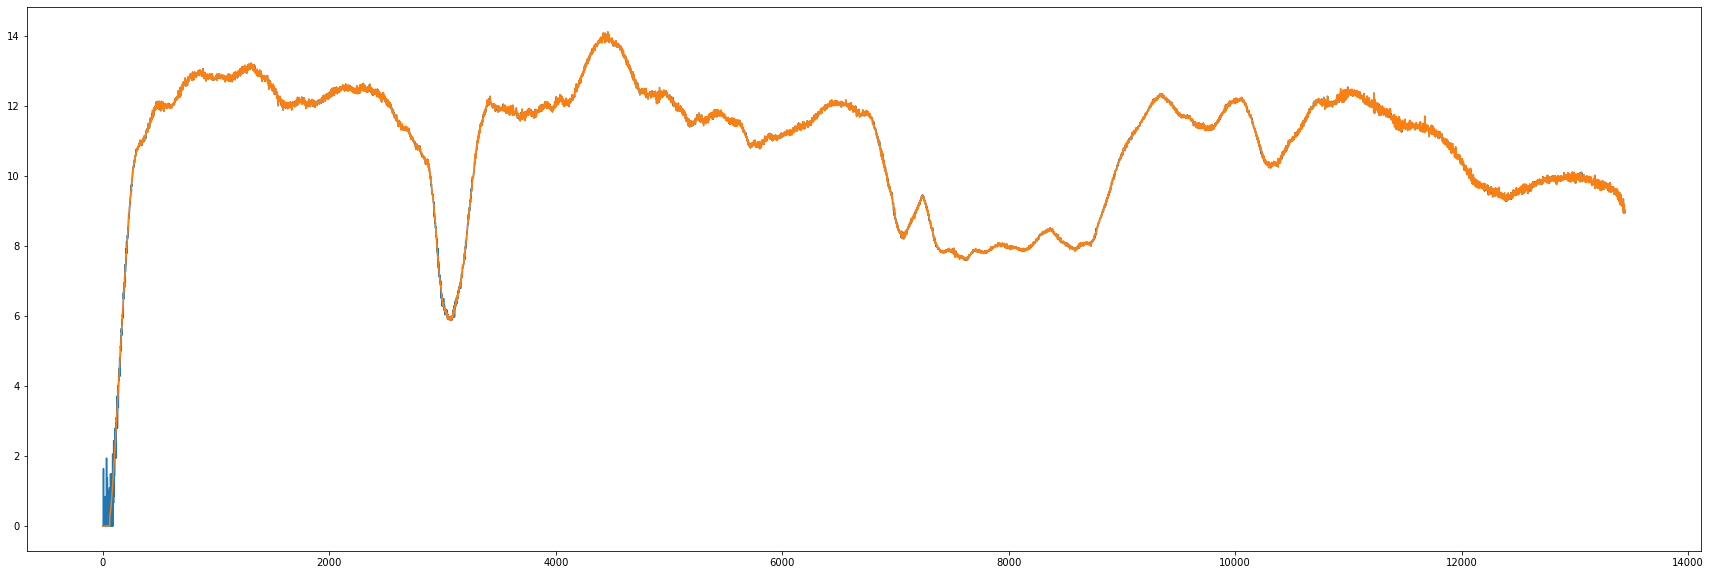

In [44]:
test_df = NvidiaDataset([root_path / "2021-10-14-13-08-51_e2e_rec_vahi_backwards"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.1, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: velocity_model.find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])